## Plot spatial variance of all terms 

In [1]:
import matplotlib.colors as colors
from matplotlib import cm,gridspec,rc
import matplotlib.pyplot as plt
import os
import utils
import warnings
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import corrstats
warnings.filterwarnings('ignore')

In [2]:
USER = os.environ['USER']

In [3]:
path = f'/glade/work/{USER}/MAPP/ETOPO'
filename = f'{path}/Etopo1_Bed_0_65N_170E_40W.nc'
bathy = xr.open_dataset(filename)
lon_e = bathy['lon']
for ii in range(len(lon_e)):
    if lon_e[ii] > 0:
        lon_e[ii] = lon_e[ii] - 360.
lat_e = bathy['lat'][300:]
depth_e = bathy['depth'][300:, :]

In [4]:
mask_bathy = (depth_e >= 0.)*1.
mask_bathy = np.ma.array(mask_bathy,mask=mask_bathy==0.)
lon_e,lat_e = np.meshgrid(lon_e,lat_e)
lon_e = np.ma.array(lon_e,mask=mask_bathy.mask)
lat_e = np.ma.array(lat_e,mask=mask_bathy.mask)

In [5]:
import matplotlib as mpl
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
new_cmapt = truncate_colormap('seismic', 0., 1.0)
new_cmaps = truncate_colormap('PuOr_r', 0.375, 1.0)

In [7]:
lat_min = 15;   lat_max = 65
lon_min = -190; lon_max = -40
#
cmin = -.01;cmax = .01;clev = 50.
dc = (cmax - cmin)/clev; vct = np.arange(cmin, cmax+dc, dc)
pal_normt = colors.BoundaryNorm(vct, ncolors=256, clip = False)
#
cmin = -.05;cmax = .25;clev = 250.
dc = (cmax - cmin)/clev; vcs = np.arange(cmin, cmax+dc, dc)
pal_norms = colors.BoundaryNorm(vcs, ncolors=256, clip = False)
# text
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#csfont = {'fontname':'Times New Roman'}

## read clim BSF

In [8]:
var_name = 'BSF'
a1,a2,b1,b2 = [240,380,125,320]
datadir = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{datadir}/DPLE-forcing_{var_name}_hindcast_clim.nc'
ds_hind = xr.open_dataset(filename)
nmon = ds_hind.dims['time']
bsf = ds_hind['BSF'][a1:a2,b1:b2]
lon = ds_hind['TLONG'][a1:a2,b1:b2] - 360.
lat = ds_hind['TLAT'][a1:a2,b1:b2]

## LME Shapes

In [9]:
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME_shapes.gmt' % path
file1 = open(filename,'r')
lines = file1.readlines()
#
nbox = -1
lonn = [[] for ii in range(194)]
latt = [[] for ii in range(194)]
ln = 9
for line in lines[ln:]:
    sl = line.split()
    if len(sl)==2 and sl[0] == '#':
        nbox = nbox + 1
    elif len(sl)==2 and sl[0] != '#':
        lonn[nbox-1].append(np.float(sl[0]))
        latt[nbox-1].append(np.float(sl[1]))
##
pp180 = []
for pp in range(len(lonn)):
    if len(lonn[pp])>0:
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        if len(np.where(np.abs(lon1 + 180.)<1e-4)[0])>0:
            if len(lonn[pp])<4:
                pp180.append(pp)
##
lon0 = []
lat0 = []
nn = 0
for pp in range(len(lonn)):
    if len(lonn[pp])!=0:
        nn = nn + 1
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        lat1 = np.array(latt[pp])
        lon1 = np.ma.array(lon1,mask=False)
        lat1 = np.ma.array(lat1,mask=False)
        if pp in pp180[1:]:
#        if len(np.where(np.abs(lon1+180.)<1e-4)[0]) > 0:
            #print(pp)
            aa = np.where(np.abs(lon1+180.)<1e-4)[0]
            lon1.mask[aa] = True
            lat1.mask[aa] = True
        lon0.append(lon1)
        lat0.append(lat1)

In [10]:
def mask_nan(var):
    """
    mask nan values
    """
    maskn = np.isnan(var)
    var = np.ma.array(var,mask=maskn)
    return var

In [11]:
terms = ["Phi'",'O2','T','S','AOU','O2sol','Resi','O2-T','O2-S','O2-Resi','T-S','AOU-T','O2sol-T','T-Resi','AOU-S','O2sol-S','S-Resi','AOU-O2sol','AOU-Resi','O2sol-Resi']

2.896715724038885e-05 0.019531194275951902
3.0485062978856703e-06 0.03640627428457218
5.562392320223211e-07 0.016839491284007264
-0.03002248375108846 0.007673607509262375
-0.008973628190044294 0.0019196776901781879
6.282077443719945e-07 0.013713804642032144
9.938313699913503e-08 0.01236908966756317
-0.013016846703430604 0.01738794712596239
-0.02647452138574193 0.004822844920377993
-0.011065095746554277 0.018662572956330167
2.660883936727305e-08 0.01794620454384944
2.987932771635519e-08 0.02139812054395358
2.1155692961520604e-11 0.005833633634737174
-0.016819851123874387 0.004879537765681374
-0.0003975019854589746 0.001558341706022542
5.092472273444537e-07 0.005329951686689404
6.830319757984405e-06 0.022667655210713473
-0.020714756543809672 0.006868431847140283
-0.010112865525686346 0.0004623501505237062
-0.009060961250694033 0.008734030215807272


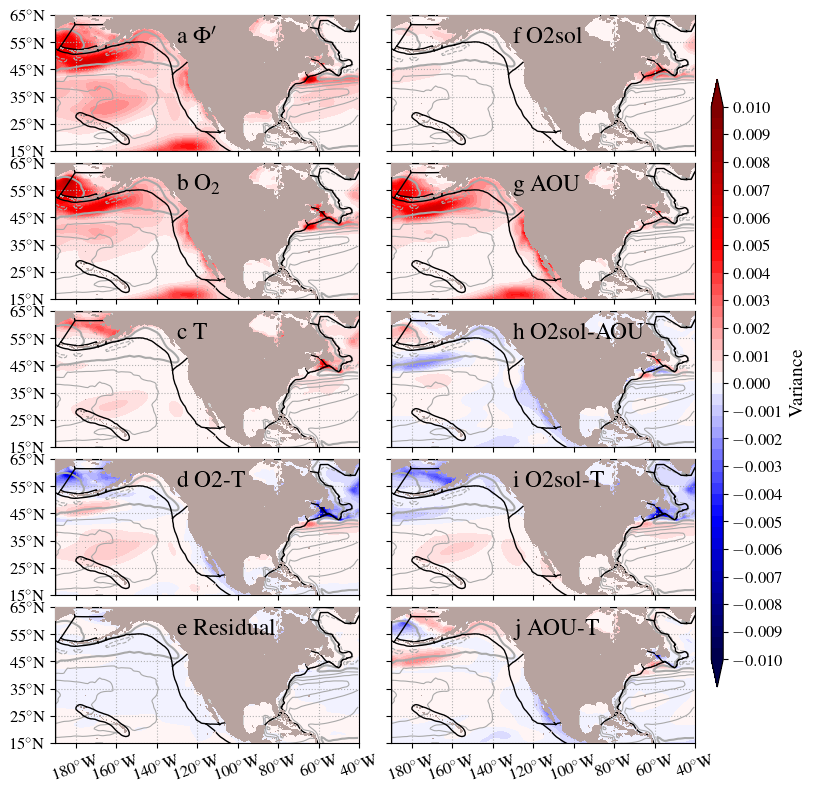

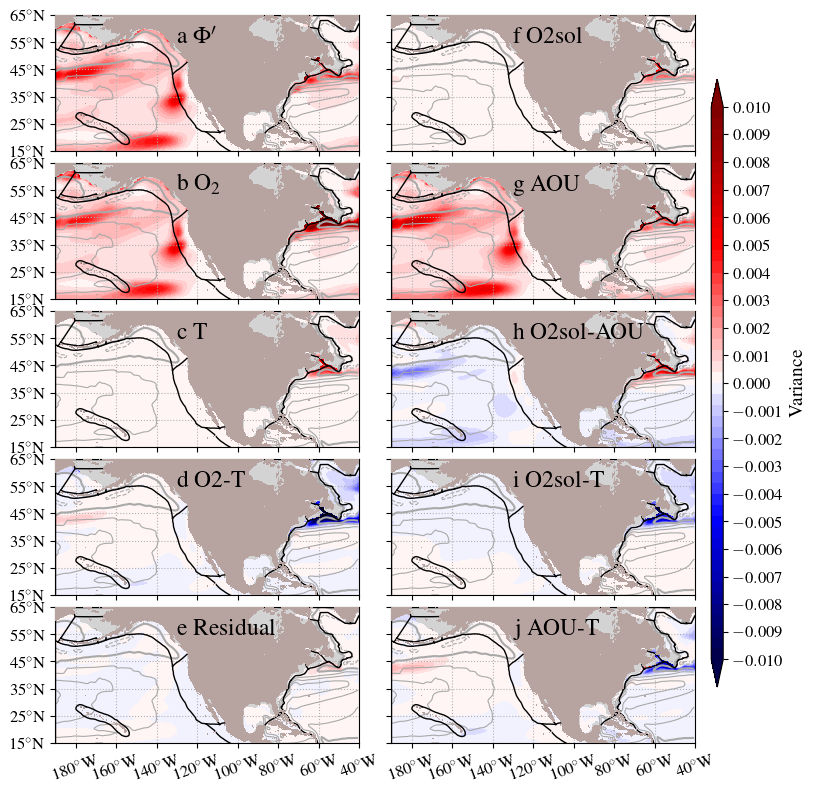

In [12]:
ngg = [['a', 'f', 'k', 'p'],\
       ['b', 'g', 'l', 'q'],\
       ['c', 'h', 'm', 'r'],\
       ['d', 'i', 'n', 's'],\
       ['e', 'j', 'o', 't']]
ngg = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
path = f'/glade/scratch/{USER}/DPLE-results'
#
nphi = 1
for layer in ['0-200m', '200-600m']:
    fig = plt.figure(figsize=[8, 8])
    gs = gridspec.GridSpec(4, 2)#, width_ratios=[1, 1, 1, 1e-2])
    # read ACC data
    # Persistence and DPLE ACC
    filename = f'{path}/FOSI_hindcast_spatial_distribution_of_variance_Phi_components_{layer}.nc'
    ds = xr.open_dataset(filename)
    vari = ds['variance'].values[nphi,:] # 20,nlat,nlon
    ## plot
    #lyy = np.array([0, 1, 3, 6, 9])
    #for gg, ldd in zip(range(5), lyy):
    for gg, mm, tit in [[0, 0, "$\Phi'$"], [1, 1, 'O$_2$'], [2, 2, 'T'], [3, 7, 'O2-T'], [4, 6, 'Residual'], \
                    [5, 5, 'O2sol'], [6, 4, 'AOU'], [7, 17, 'O2sol-AOU'], [8, 12, 'O2sol-T'], [9, 11,'AOU-T']]:
        xj = int(np.floor(gg/5))
        xi = gg - xj*5
            #ax = fig.add_subplot(gs[gg, mm])
            #ax = fig.add_axes([0.06+mm*0.29, 0.05+(4-gg)*0.185, 0.27, 0.17])
        ax = fig.add_axes([0.06+xj*0.42, 0.05+(4-xi)*0.185, 0.38, 0.17])
        #
        xrr = np.arange(lon_min-10, lon_max+10)
        ax.fill_between(xrr, np.ones(len(xrr))*(lat_min-10), np.ones(len(xrr))*(lat_max+10), color='lightgray')
        for pp in range(len(lon0)):
            ax.plot(lon0[pp], lat0[pp], color='k', linewidth=1., zorder=19)
        ax.contour(lon, lat, bsf, [-10], linestyles='dashed', colors='darkgray', linewidths=.8)
        ax.contour(lon, lat, bsf, [0], linestyles='solid', colors='darkgray', linewidths=1.5)
        ax.contour(lon, lat, bsf, [10, 20, 30, 40], linestyles='solid', colors='darkgray', linewidths=.8)
        if gg != 4 :
            cd = ax.contourf(lon, lat, vari[mm], vct, shading='nearest', cmap=new_cmapt, norm=pal_normt, extend='both')
            print(np.nanmin(vari[mm]), np.nanmax(vari[mm]))
        else:
            #vv = vari[mm,ldd] + vari[9,ldd] + vari[13,ldd] + vari[16,ldd] + vari[3,ldd] + vari[8,ldd] + vari[10,ldd]
            vv = vari[0] - (vari[1] + vari[2] + vari[7])
            cd = ax.contourf(lon, lat, vv, vct, shading='nearest', cmap=new_cmapt, norm=pal_normt, extend='both')
            print(np.nanmin(vv), np.nanmax(vv))
            #
#            if mm == 0:
#                lon1 = np.ma.array(lon, mask=~pmask[ldd])
#                lat1 = np.ma.array(lat, mask=~pmask[ldd])
#                ax.scatter(lon1[::4, ::2], lat1[::4, ::2], s=5, marker='.', color='k', alpha=1, linewidth=.5)
#            elif mm == 1:
#                lon1 = np.ma.array(lon, mask=~maskk[ldd])
#                lat1 = np.ma.array(lat, mask=~maskk[ldd])
#                ax.scatter(lon1[::4, ::2], lat1[::4, ::2], s=5, marker='.', color='k', alpha=1, linewidth=.5)
#            elif mm == 2:
#                lon1 = np.ma.array(lon, mask=(~maskk[ldd]+~smask[ldd]+~maskp[ldd]))
#                lat1 = np.ma.array(lat, mask=(~maskk[ldd]+~smask[ldd]+~maskp[ldd]))
#                ax.scatter(lon1[::4, ::2], lat1[::4, ::2], s=5, marker='.', color='k', alpha=1,linewidth=.5)#,
            #
        ax.pcolor(lon_e,lat_e,mask_bathy,shading='nearest',cmap=cm.terrain_r,vmin=.5,vmax=4,zorder=20)
            #ax.text(-130, 58, f'LY {gg+1}', fontsize=14, fontweight='bold', zorder=21)
            #ax.text(-130, 54, var, fontsize=14, fontweight='bold', zorder=21)
        ax.text(-130, 55, '%s %s' % (ngg[gg], tit), fontsize=17, fontweight='bold', zorder=21)
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_xticks(np.arange(-180, -30, 20))
        ax.set_yticks(np.arange(15, 66, 10))
            #if mm == 0:
            #    ax.set_ylabel('Lead Year %d' % (ldd+1), fontsize=14, fontweight='bold')
        #if gg == 0:
        #    ax.set_title(tit, fontsize=18, fontweight='bold')
            #
        xtl = []
        for ii in np.arange(-180, -30, 20):
            if ii < -180:
                ii = ii + 360
                ff = 'E'
            elif ii >= -180:
                ff = 'W'
            elif np.abs(ii-0) < 1e-5:
                ff = ''
            xtl.append('%d$^\circ$%s' % (abs(ii), ff))
        ytl = []
        for jj in np.arange(15, 66, 10):
            if jj < 0:
                ff = 'S'
            elif jj > 0:
                ff = 'N'
            elif np.abs(jj-0) < 1e-5:
                ff = ''
            ytl.append('%d$^\circ$%s' % (abs(jj), ff))
        if gg in [4,9]:
            ax.set_xticklabels(xtl, fontsize=12, fontweight='bold', rotation=20)
        else:
            ax.set_xticklabels([], fontsize=12, fontweight='bold', rotation=20)
        if gg < 5:
            ax.set_yticklabels(ytl, fontsize=12, fontweight='bold')
        else:
            ax.set_yticklabels([], fontsize=12, fontweight='bold')
        ax.plot([lon_min, lon_max], [lat_max, lat_max], color='k', linewidth=1, zorder=10)
        ax.plot([lon_min, lon_min], [lat_min, lat_max], color='k', linewidth=1, zorder=10)
        ax.grid(linestyle='dotted', zorder=11)
        # colorbar
        if gg == 0 and mm == 0:
            cbaxes = fig.add_axes([0.88, 0.12, 0.015, 0.76])
            cb = plt.colorbar(cd, orientation="vertical", cax=cbaxes, extend='max', ticks=np.arange(-.1,.1,1e-3))
            cb.ax.tick_params(labelsize=12)
            cb.set_label(label='Variance', fontsize=14, fontweight='bold')
#            elif gg == 0 and mm == 2:
#                cbaxes = fig.add_axes([0.92, 0.06, 0.015, 0.42])
#                cb = plt.colorbar(cd, orientation="vertical", label='ACC', cax=cbaxes, extend='both', ticks=[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
#                cb.ax.tick_params(labelsize=12)
#                cb.set_label(label='$\Delta$ACC', fontsize=14, fontweight='bold')
    #plt.tight_layout()
    #
    output = f'/glade/scratch/{USER}/DPLE-plots'
    outfile = f'{output}/FOSI_spatial_Phi_components_variance_{nphi}_{layer}_leadyear1-5.png'
    plt.savefig(outfile, dpi=400)
plt.show()